# Regularized Linear Regression, Bias & Variance
<br>
In this tutorial, we will implement regularized linear regression (think all the way back to the first assignment) and explore the importance concepts of **bias** and **variance** in machine learning. When working with predictions, we want to use an algorithm that produces low error and generalizes well for new, unseen data. However we often want to increase the performance of our algorithm, so how can we do so? Some solutions include:
- getting more training examples
- using more/less features
- using complex features
- increasing or decreasing our $\lambda$ regularization parameter

So many different options to choose from! For example, how do we know when do use more or less features? Fear not, this assignment explores which techniques to apply in which situations so that our machine learning algorithm is optimal.
We will start off with visualizing our dataset, which examines the relationship between a change in water level vs. water flowing out of a dam.

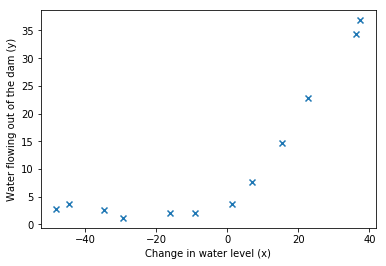

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_tnc
import random
from sklearn.preprocessing import PolynomialFeatures

data = scipy.io.loadmat("ex5data1.mat")

X = data["X"] # training set
Xtest = data["Xtest"] # test set
Xval = data["Xval"] # validation set

y = data["y"] # labels for training set
ytest = data["ytest"] # labels for test set
yval = data["yval"] # labels for validation set

# plot only X and y

plt.scatter(X, y, marker="x")
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.show()

Note that the data given to us is split into three sets: a *training set*, a *test set*, and a *validation set* (also referred as a *cross validation* set in this assignment), and there is a good reason why we do this split.

Suppose we did not split our data but instead trained our linear regression algorithm on the entire dataset. Our fitted parameters would not generalize well with new unknown data, since it's overfitted to our specific data. So let's split our data into two sets, one for training and one for testing. We are going to fit our $\theta$ parameter using only the training set and then evaluate our algorithm's performance on the previously untouched test set.

Everything sounds good so far, but there is a slight problem. Let's say in order to increase the performance of our regression algorithm, we want to experiment with higher order polynomials because we think that having a more complex function will reduce our test (and training) error. After experimenting with different polynomial degrees, we find one that is not too high or not too low, and minimizes the test error. **But**, notice that we "fit" our polynomial degree using our test set! Thus, our model is unlikely to generalize well for new, unseen data outside of our training and test sets.

The solution is to segment one more set called the *validation set*. As before, we still use the training set to train our model but we use the validation set (instead of the test set) to fit the polynomial degree which minimizes the *validation error*. Finally we can evaluate our algorithms performance on the untouched test set.

Ok I digress, let's continue with implementing regularized linear regression.

In [3]:
X_with_bias = np.insert(X,0,1,axis=1) # insert bias column to training set
X_with_bias

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

Recall the equations for regularized linear regression below:
<br>
<br>
\begin{align}
h_\theta(x) &= \theta_0 + \theta_1x_1 + ... + \theta_nx_n \\
cost &= \frac{1}{2m} \sum_{i = 1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m} \sum_{j = 1}\theta_j^2 \\
gradient &= \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}~\text{for j = 0} \\
gradient &= \left(\frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\right) + \frac{\lambda}{m}\theta_j~\text{for j $\ge$ 0}
\end{align}

Below are their vectorized implementations. Remember that we don't include $\theta_0$ in the regularization term calculation!

In [57]:
def linearRegCostFunction(theta, X, y, lamda):
    # assumes bias column inserted
    X = np.matrix(X)
    theta = np.matrix(theta)
    m = X.shape[0]
    thetaNoBias = np.copy(theta)
    thetaNoBias[:,0] = 0 # for regularization
    
    firstTerm = np.sum(np.square((X * theta.T) - y))/(2*m)
    regTerm = (lamda/(2*m)) * (np.sum(np.square(thetaNoBias)))
    cost = firstTerm + regTerm
    return cost
    
theta = [1,1]

def linearRegGradient(theta, X, y, lamda):
    # assumes bias column inserted
    X = np.matrix(X)
    theta = np.matrix(theta)
    m = X.shape[0]
    thetaNoBias = np.copy(theta)
    thetaNoBias[:,0] = 0 # for regularization
    
    gradient = ((X * theta.T - y).T * X)/m + (lamda/m)*thetaNoBias
    return np.array(gradient)[0]

print(linearRegCostFunction(theta,X_with_bias,y,1))
print(linearRegGradient(theta,X_with_bias,y,1))

303.99319222
[ -15.30301567  598.25074417]


For $\theta$ initialized to ones, we see that the cost and gradients match the values indicated on the assignment.

Next we are going to use `fmin_tnc` to train the $\theta$ parameter which minimizes our cost function and plot our result!

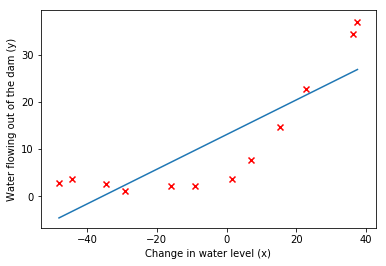

In [5]:
def trainLinearReg(X,y,lamda):
    n = X.shape[1]
    zeroTheta = np.zeros(n)
    minimum = fmin_tnc(func=linearRegCostFunction, x0=zeroTheta, fprime=linearRegGradient,
                  args=(X,y,lamda))
    return minimum[0]

lamda = 0
trainedTheta = trainLinearReg(X_with_bias,y,lamda)

xrange = np.linspace(X.min(),X.max(),100)
yline = trainedTheta[1] * xrange + trainedTheta[0] # y = theta_1*x + theta_0
plt.plot(xrange,yline)
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.scatter(X,y,marker='x',color='r')
plt.show()

Looks good! Except that a simple line clearly does not fit the training data well, let alone generalize well for new data. This is a case of **high bias**, as the model *underfits* the data. High bias occurs when the model is too simple but the advantage is that they are fast to train and easy to understand. This contrasts **high variance** which occurs when the overly complex model *overfits* the data such that high error will occur with new, unseen data.

Not always are we able to construct a graph similar to the one above and from there deduce if there is a high bias or high variance problem. Thus we use something called a **learning curve**, which examines the relationship between training set size vs. error. 

The idea is that when training set size is small, training error is low because a model can fit the data pretty well (for example, if there are only one or two data points, then a line will fit them perfectly). But validation error is going to be high for small training sets because our model doesn't generalize well. But as training set size increases, training error should increase also (due to a model not being able to fit large data points perfectly) whereas validation error should decrease (due to the model being trained on more data, thus generalizing better).

Let's examine the learning curve for our simple linear regression model above!

In [6]:
def learningCurve(X,y,Xval,yval,lamda):
    # assume bias column added in already
    m = len(X)
    error_train = []
    error_val = []
    for i in range(1,m+1):
        X_trainSubset = X[:i,:] # select i rows and all columns
        y_subset = y[:i]
        
        # fit theta for each training subset and then compute training and cv error
        trainedTheta = trainLinearReg(X_trainSubset, y_subset, lamda)
        
        # don't use regularization when computing errors!
        # note that error is just cost
        trainingError = linearRegCostFunction(trainedTheta,X_trainSubset,y_subset,0)
        cvError = linearRegCostFunction(trainedTheta,Xval,yval,0)
        error_train.append(trainingError)
        error_val.append(cvError)
        
    return error_train, error_val

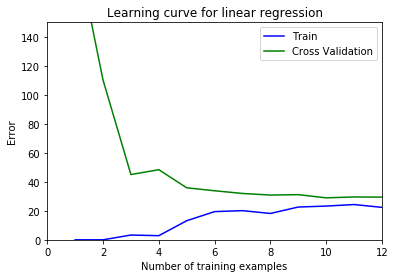

In [7]:
Xval_with_bias = np.insert(Xval, 0, 1, axis=1)
lamda = 0
errors = learningCurve(X_with_bias,y,Xval_with_bias,yval,lamda)
trainError = errors[0]
valError = errors[1]
m = X_with_bias.shape[0]

def plotLearningCurve(m, trainError, valError):
    xrange = np.arange(1,m+1)
    plt.plot(xrange,trainError,color='b',label="Train")
    plt.plot(xrange,valError,color='g',label="Cross Validation")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error")
    plt.title("Learning curve for linear regression")
    plt.legend()
    plt.axis([0, 12, 0, 150])
    plt.show()

plotLearningCurve(m,trainError, valError)

The above learning curve shows not much of a gap between validation and training error. Moreover both errors are high, which signals a *high bias* scenario. Note that by extrapolating the two curves, training and validation errors plateau at a certian level. Therefore in a *high bias* scenario, adding more training data is unlikely to increase the performance of the model, as training and validation errors are likely to stay relatively constant.

Let's increase the complexity (and the *variance*) of our model by performing regularized polynomial regression instead of linear. The hypothesis equation is going to look like:

$$
h_{\theta}(x) = \theta_0 + \theta_1 (waterLevel) + \theta_2(waterLevel)^2 + ... + \theta_p(waterLevel)^p
$$


In [8]:
def polyFeatures(X, p):
    poly = PolynomialFeatures(degree=p)
    return poly.fit_transform(X)[:,1:] # remove x^0 column

p = 8 # polynomial degree 8
polyDf = polyFeatures(X,p)
pd.DataFrame(polyDf)

,0,1,2,3,4,5,6,7
0,-15.936758,253.980260,-4047.621971,6.450597e+04,-1.028016e+06,1.638324e+07,-2.610958e+08,4.161020e+09
1,-29.152979,849.896197,-24777.006175,7.223235e+05,-2.105788e+07,6.139000e+08,-1.789701e+10,5.217513e+11
2,36.189549,1309.683430,47396.852168,1.715271e+06,6.207487e+07,2.246462e+09,8.129843e+10,2.942154e+12
3,37.492187,1405.664111,52701.422173,1.975892e+06,7.408050e+07,2.777440e+09,1.041323e+11,3.904148e+12
4,-48.058829,2309.651088,-110999.127750,5.334488e+06,-2.563693e+08,1.232081e+10,-5.921235e+11,2.845676e+13
5,-8.941458,79.949670,-714.866612,6.391950e+03,-5.715335e+04,5.110343e+05,-4.569391e+06,4.085702e+07
6,15.307793,234.328523,3587.052500,5.490986e+04,8.405487e+05,1.286695e+07,1.969645e+08,3.015092e+09
7,-34.706266,1204.524887,-41804.560890,1.450880e+06,-5.035463e+07,1.747621e+09,-6.065341e+10,2.105053e+12
8,1.389154,1.929750,2.680720,3.723935e+00,5.173120e+00,7.186262e+00,9.982827e+00,1.386769e+01
9,-44.383760,1969.918139,-87432.373590,3.880577e+06,-1.722346e+08,7.644420e+09,-3.392881e+11,1.505888e+13


We also need to perform feature normalization, similar to the first assignment.

In [9]:
def featureNormalize(poly):
    n = poly.shape[1]
    mu = np.mean(poly, axis=0)
    X_norm = poly - mu
    sigma = np.std(poly, axis=0)
    X_norm = poly / sigma
    return X_norm, mu, sigma

scaled_df, mu, sigma = featureNormalize(polyDf.copy()) # keep original df, make copy to modify

X_poly = np.insert(scaled_df, 0, 1, axis=1) # insert bias column, training data with polynomial degrees
X_poly_val = polyFeatures(Xval.copy(), p) # validation set with polynomial degrees

# X_poly_val = X_poly_val - mu # not sure why not subtracting mu gives better results
X_poly_val = X_poly_val / sigma
X_poly_val = np.insert(X_poly_val, 0, 1, axis=1) # insert bias column

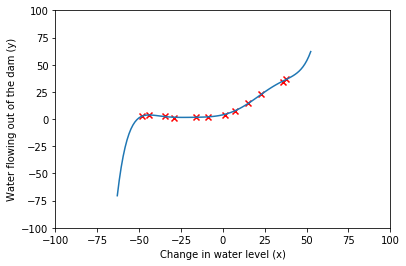

In [38]:
lamda = 0
trainedTheta = trainLinearReg(X_poly,y,lamda)
n_trained = len(trainedTheta)
trainedTheta = np.reshape(trainedTheta, (n_trained,1))

def plotFit(min_x, max_x, mu, sigma, theta, p):
    entries = 100
    xRange = np.linspace(min_x-15,max_x+15,entries)
    xRange = np.reshape(xRange, (entries,1)) # 100x1 matrix
    X_poly_x_axis = polyFeatures(xRange, p) # 100x8 matrix
    
    #X_poly_x_axis = X_poly_x_axis - mu 
    # no idea why you have to comment the above out
    # if you do subtract by mu, graph is slightly shifted upward from points
    
    X_poly_x_axis = X_poly_x_axis / sigma
    X_poly_x_axis = np.insert(X_poly_x_axis,0,1,axis=1)
    yline = np.dot(X_poly_x_axis,theta)
    return xRange, yline

xRange, yline = plotFit(X.min(), X.max(), mu, sigma, trainedTheta, p)
plt.plot(xRange,yline)
plt.scatter(X,y,marker='x',color='r')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.axis([-100,100,-100,100])
plt.show()

Our complex polynomial fits all of the points perfectly! But judging by the endpoints of the curve, it seems that our model still won't generalize well for new data. Let's plot the learning curve to see the performance.

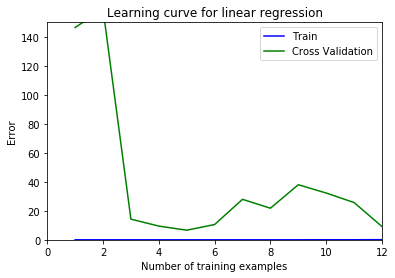

In [39]:
errors = learningCurve(X_poly, y, X_poly_val, yval, lamda)
plotLearningCurve(m,errors[0], errors[1])

Seems like training error is low with validation error larger than the training error. When there is a large difference between validation and training error, but training error is low, this signals a *high variance* situation. Because the validation error is not leveling off, adding more training data to the model would likely help increase its performance.

To decrease the variance, let's increase and experiment with different $\lambda$ values.

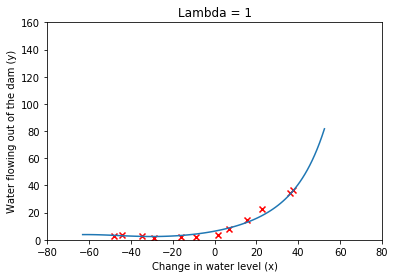

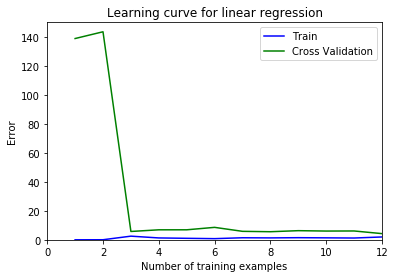

In [60]:
lamda = 1
trainedTheta = trainLinearReg(X_poly,y,lamda)
n_trained = len(trainedTheta)
trainedTheta = np.reshape(trainedTheta, (n_trained,1))

xRange, yline = plotFit(X.min(), X.max(), mu, sigma, trainedTheta, p)
plt.plot(xRange,yline)
plt.scatter(X,y,marker='x',color='r')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.axis([-80,80,0,160])
plt.title("Lambda = 1")
plt.show()

errors = learningCurve(X_poly, y, X_poly_val, yval, lamda)
plotLearningCurve(m,errors[0], errors[1])

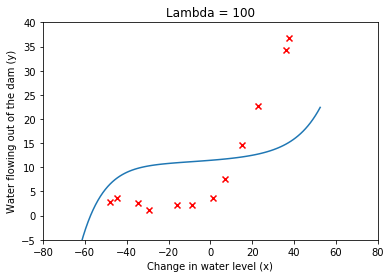

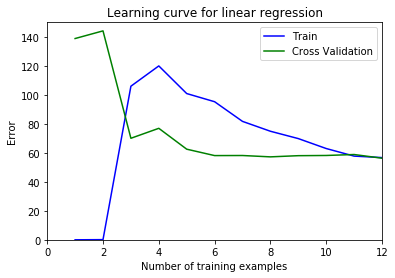

In [41]:
lamda = 100
trainedTheta = trainLinearReg(X_poly,y,lamda)
n_trained = len(trainedTheta)
trainedTheta = np.reshape(trainedTheta, (n_trained,1))

xRange, yline = plotFit(X.min(), X.max(), mu, sigma, trainedTheta, p)
plt.plot(xRange,yline)
plt.scatter(X,y,marker='x',color='r')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.axis([-80,80,-5,40])
plt.title("Lambda = 100")
plt.show()

errors = learningCurve(X_poly, y, X_poly_val, yval, lamda)
plotLearningCurve(m,errors[0], errors[1])

Seems like $\lambda = 1$ gives good performance whereas $\lambda = 100$ causes the a high bias model again, which is expected. 

How can we determine what is the optimal $\lambda$ value? We can plot something similar to a learning curve but instead of varying training set size, we can vary $\lambda$ values.

[ 7.36244318  6.52208022  3.82495701  3.61985054  2.18390614  2.10600379
  1.28077774  1.28790208  0.72486957]


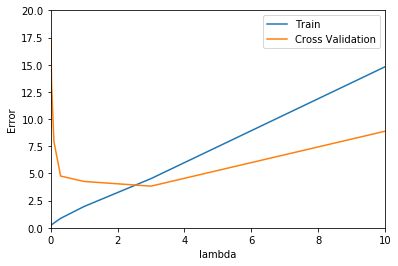

In [61]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

def validationCurve(X,y,Xval,yval):
    global lambda_vec
    error_train = []
    error_cv = []
    
    for lamda in lambda_vec:
        
        trainedTheta = trainLinearReg(X,y,lamda)
        if lamda == 3:
            print(trainedTheta)
        # note that computing training and cv error, don't use regularization term
        trainingError = linearRegCostFunction(trainedTheta,X,y,0)
        cvError = linearRegCostFunction(trainedTheta,Xval,yval,0)
        error_train.append(trainingError)
        error_cv.append(cvError)
    
    return error_train, error_cv

errors = validationCurve(X_poly,y,X_poly_val,yval)

# plotting

trainingError = errors[0]
cvError = errors[1]
plt.plot(lambda_vec, trainingError, label="Train")
plt.plot(lambda_vec, cvError, label="Cross Validation")
plt.xlabel("lambda")
plt.ylabel("Error")
plt.legend()
plt.axis([0,10,0,20])
plt.show()

Looks like $\lambda = 3$ is the optimal regularization parameter which yields the lowest validation and training errors. The learning curve below confirms that it does perform slightly better than $\lambda = 1$.

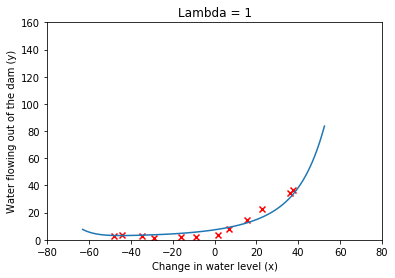

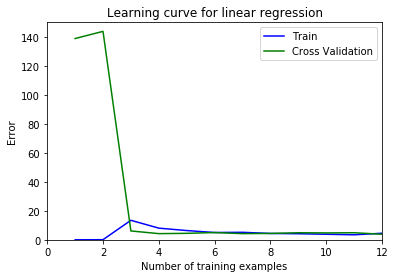

In [62]:
lamda = 3
trainedTheta = trainLinearReg(X_poly,y,lamda)
n_trained = len(trainedTheta)
trainedTheta = np.reshape(trainedTheta, (n_trained,1))

xRange, yline = plotFit(X.min(), X.max(), mu, sigma, trainedTheta, p)
plt.plot(xRange,yline)
plt.scatter(X,y,marker='x',color='r')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.axis([-80,80,0,160])
plt.title("Lambda = 1")
plt.show()

errors = learningCurve(X_poly, y, X_poly_val, yval, lamda)
plotLearningCurve(m,errors[0], errors[1])

Congrats for making it through assignment 5! This assignment is really helpful for learning how to "debug" your machine learning algorithm and increase their performance. In the next tutorial, we will explore another machine learning algorithm called **Support Vector Machines**. See you there! :) 